In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

1. What was the biggest bank at the end of 2009?

In [100]:
# assume 2009Q4 to be the end of 2009
df = pd.read_excel('Bank failure data.xlsx')
df[df['Quarter']=='2009Q4'].sort_values('Size',ascending = False).iloc[0,0]

'Citibank (South Dakota), N.A.'

2. What trends do you observe in net chargeoffs over time?

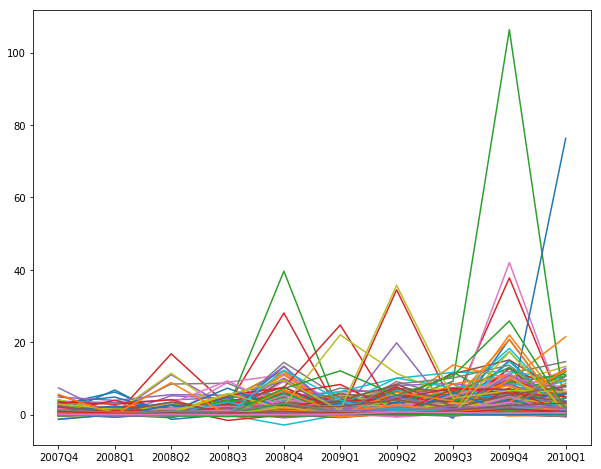

In [95]:
plt.figure(figsize=(10,8))
df.groupby('Bank Name').apply(lambda df: plt.plot(df['Quarter'],df['Net Chargeoffs']))
#plot.scatter('Net Chargeoffs','Quarter')
plt.show()

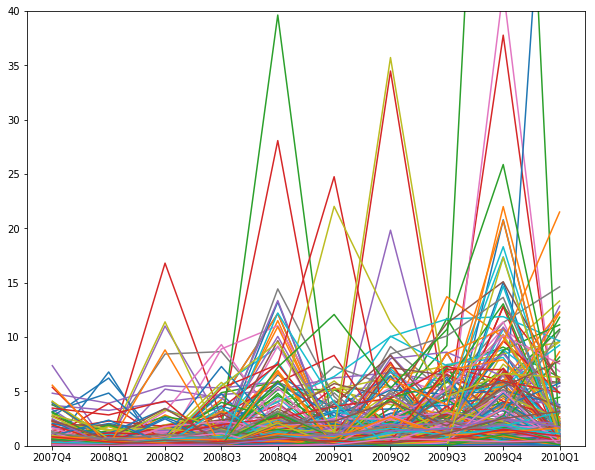

In [96]:
# zoom in by limiting the y axis
plt.figure(figsize=(10,8))
df.groupby('Bank Name').apply(lambda df: plt.plot(df['Quarter'],df['Net Chargeoffs']))
#plot.scatter('Net Chargeoffs','Quarter')
plt.ylim(0,40)
plt.show()

We can see from the graphs above that the net chargeoffs seem cyclical for most banks. It peaks in Q2 in Q4 and hits bottom in Q1 and Q3. In the second graph, more clearly, many banks have increasing net chargeoffs overtime - they have higher peaks as x increases.

3. Is there a correlation between level of profitability of a bank’s investments in
securities (here measured by fair value of investments over cost basis) and
bank failure?

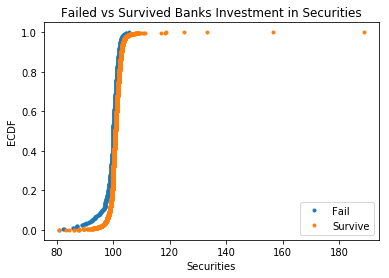

t_value = 8.92269676598558
p_value = 1.6439748696225495e-17


In [101]:
# First, let's get dummies for the bank failure column and see if 
# it's correlated with Securities
dummy = pd.get_dummies(df
               ['Failed during 2010Q2'],prefix='Fail').iloc[:,1:]
df = pd.concat([df, dummy],axis = 1)

# draw ECDF plot to see the distribution
import numpy as np
x1 = np.sort(df[df['Fail_Yes'] ==1]['Securities'])
x2 = np.sort(df[df['Fail_Yes'] ==0]['Securities'])
y1 = np.arange(1,len(x1)+1) / len(x1)
y2 = np.arange(1,len(x2)+1) / len(x2)
plt.plot(x1,y1,marker = '.',linestyle='none')
plt.plot(x2,y2,marker = '.',linestyle='none')
lgd = ['Fail','Survive']
plt.legend(lgd)
plt.title('Failed vs Survived Banks Investment in Securities')
plt.xlabel('Securities')
plt.ylabel('ECDF')
plt.show()

# Conduct one way anova test to see 
F, p = stats.f_oneway(df[df['Fail_Yes'] == 0]['Securities'],df[df['Fail_Yes'] == 1]['Securities'])
print("F = " + str(t_value))
print("p = " + str(2*p_value))

We can see from the graph that banks who survived generally invested more in securities than banks who failed. All of the latter invested less than 110. But we can't really tell if the difference is significant based on the graph.

Based on the Anova analysis, we can see from the F and p values that there is a signficant difference in securities between banks who fails and banks who didn't fail. Therefore we conclude that there is a negative correlation between securities and bank failure.


4. What are the top two predictors of bank failure?

In [102]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)
  
# building the model based on the data before 2010Q1
df1 = df[df['Quarter']!= '2010Q1'] 
# drop text columns
df1 = df1.iloc[:,2:] 
df1 = df1.drop('Failed during 2010Q2',axis = 1) 
# handle missing data
df1 = df1.fillna(df1.mean())
# split into train and test (validation) to avoid overfitting
train, test = train_test_split(df1, test_size = 0.34) 
# build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('Fail_Yes', axis=1), train['Fail_Yes'])
  
#check OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['Fail_Yes'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.969307341352136 
 OOB Confusion Matrix 
       0    1
0  2144   17
1    57  193


In [105]:
#check print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('Fail_Yes', axis=1),test['Fail_Yes']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['Fail_Yes'], rf.predict(test.drop('Fail_Yes', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9646017699115044 
 Test Set Confusion Matrix 
       0    1
0  1098    8
1    36  101


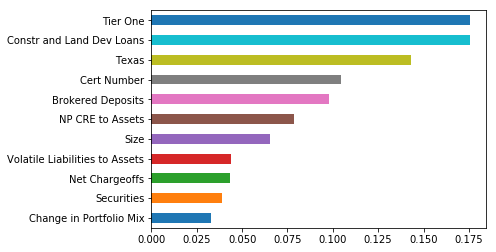

In [106]:
# checking variables
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('Fail_Yes', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

From the analysis above, we can see the top predictors are Tier One and Constr and Land Dev Loans.

5. Which banks are most likely to fail in the near future (and why)?

In [107]:
latest_data = df[(df['Quarter'] == '2010Q1')
                & (df['Failed during 2010Q2'] == 'No')]

In [108]:
latest_data = latest_data.iloc[:,2:]
latest_data = latest_data.drop('Failed during 2010Q2',axis = 1) # drop text columns
latest_data = latest_data.drop('Fail_Yes',axis = 1)
latest_data = latest_data.fillna(latest_data.mean())

In [109]:
latest_data['predicted'] = rf.predict(latest_data)

In [110]:
failing_index = latest_data[latest_data['predicted'] == 1].index

In [111]:
print ("Banks likely to fail:")
[df.loc[x,'Bank Name'] for x in failing_index]

['State Central Bank',
 'Bank of Perry',
 'Darby Bank & Trust Company',
 'ShoreBank',
 'Metropolitan National Bank',
 'Gulf State Community Bank',
 'North Alabama Bank',
 'Paragon Commercial Bank',
 'Oglethorpe Bank',
 'Legacy Bank',
 'Community Bank of Rockmart']